# Music Recommendation System
### Using Collaborative Filtering Techniques

Author: Shagufta Anjum

## Importing libraries

In [1]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statistics

## Reading Data

This dataset is Taste Profile subset of the Million Songs Dataset available at http://millionsongdataset.com/tasteprofile/. 

In [2]:
dataframe = pd.read_csv('kaggle_visible_evaluation_triplets.txt', delimiter="\t", names=["userid", "songid", "counts"])

In [3]:
dataframe.head()

,userid,songid,counts
0,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOBONKR12A58A7A7E0,1
1,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOEGIYH12A6D4FC0E3,1
2,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOFLJQZ12A6D4FADA6,1
3,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOHTKMO12AB01843B0,1
4,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SODQZCY12A6D4F9D11,1


Each row contains the following data: user ID, song ID of the song played by the user, and the no. of times that song was played by the user.

In [4]:
dataframe.shape

(1450933, 3)

The dataset has data for a total of 1450933 user-song-counts triplets.

In [5]:
# Number of unique songs and users

n_users = dataframe.userid.unique().shape[0]
n_items = dataframe.songid.unique().shape[0]

print('Number of unique users: ', n_users)
print('Number of unique songs: ', n_items)

Number of unique users:  110000
Number of unique songs:  163206


Since the dataset is very big, computation is difficult. So, we take a sample of 100000 rows as a representation of the entire dataset.

In [6]:
# Top 100000 rows
df = dataframe[:100000]

# To randomly pick the sample:
# df = dataframe.sample(n = 100000)

In [7]:
# Number of unique songs and users in subset

n_users = df.userid.unique().shape[0]
n_items = df.songid.unique().shape[0]

print('Number of unique users: ', n_users)
print('Number of unique songs: ', n_items)

Number of unique users:  7526
Number of unique songs:  41194


## Exploratory Data Analysis

In [8]:
# Checking for missing values

print('Number of missing values across columns: \n',df.isnull().sum())

Number of missing values across columns: 
 userid    0
songid    0
counts    0
dtype: int64


There are no missing values in the dataset.

### Most Popular Songs

In [9]:
# Counting how many rows are there per song and picking the top 10

pop_songs = df.groupby('songid')['counts'].count().reset_index().sort_values(['counts', 'songid'], ascending = [0,1])
pop_songs['percentage']  = round(pop_songs['counts'].div(pop_songs['counts'].sum())*100, 2)
pop_songs.columns = ['Song ID', 'No. of users that played this song', 'Percentage of total plays']
top_ten = pop_songs[:10]
top_ten

,Song ID,No. of users that played this song,Percentage of total plays
9622,SOFRQTD12A81C233C0,340,0.34
1394,SOAUWYT12A81C206F1,308,0.31
2648,SOBONKR12A58A7A7E0,304,0.30
30752,SOSXLTC12AF72A7F54,281,0.28
1557,SOAXGDH12A8C13F8A1,280,0.28
23122,SONYKOW12AB01849C9,234,0.23
7282,SOEGIYH12A6D4FC0E3,214,0.21
18742,SOLFXKT12AB017E3E0,205,0.20
5794,SODJWHY12A8C142CCE,189,0.19
9217,SOFLJQZ12A6D4FADA6,170,0.17


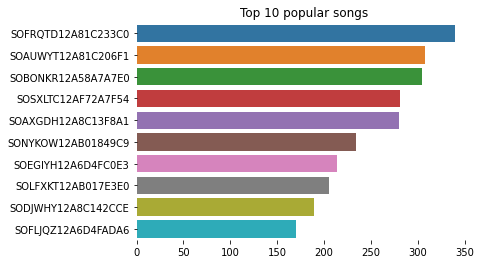

In [10]:
labels = top_ten['Song ID'].tolist()
counts = top_ten['No. of users that played this song'].tolist()

plt.figure()
sns.barplot(x=counts, y=labels).set_title("Top 10 popular songs")
sns.despine(left=True, bottom=True)

### Number of songs listened to per user

In [11]:
count_per_user = df.groupby('userid')['counts'].count()
count_per_user = pd.DataFrame(count_per_user)
count_per_user.sort_values(by = count_per_user.columns[0], inplace = True)
count_per_user.rename(columns = {'counts': 'No. of songs played'}, inplace = True)
count_per_user

,No. of songs played
userid,
d3847265d2437f145b4a02c6c96df104f4ba165e,1
82bc6c3eb139e7b024f085e1077675a4aef12476,5
52b60e8711f9acfa9e6e6fb7ae07a9cf331f0b94,5
52b28022c53e0472c57a51f349031a7116e7a034,5
52b20c3032e2116c9cd40b0a9f768329a56d04b9,5
...,...
13cee37ea2e198ce8354a962b118c1770db351d6,46
3f3984c156def23041b2bd2bfb8884f57f5f2d66,47
e48ec63ed90a119eafe5338b18850ad2502e6910,47


In [12]:
print('\nAvg number of songs played per user: ', statistics.mean(count_per_user[count_per_user.columns[0]].tolist()))


Avg number of songs played per user:  13.287270794578793


array([[<AxesSubplot:title={'center':'No. of songs played'}>]],
      dtype=object)

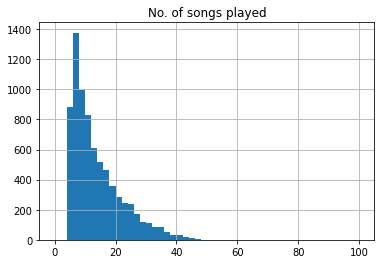

In [13]:
# Distribution of play counts per user

%matplotlib inline
count_per_user.hist(bins=50, range=(0,100))

### Number of times each song is played

In [14]:
count_per_song = df.groupby('songid')['counts'].count()
count_per_song = count_per_song.to_frame()
count_per_song.sort_values(by=count_per_song.columns[0], inplace = True)
count_per_song.rename(columns = {'counts': 'No. of times played'}, inplace = True)
count_per_song

,No. of times played
songid,
SOAAAGQ12A8C1420C8,1
SOOSSHM12A8C13500B,1
SOOSRZN12AB017D546,1
SOOSQQF12AB01868EA,1
SOOSPPT12AC4688744,1
...,...
SOAXGDH12A8C13F8A1,280
SOSXLTC12AF72A7F54,281
SOBONKR12A58A7A7E0,304


In [15]:
print('\nAvg number of plays per song: ', statistics.mean(count_per_song[count_per_song.columns[0]].tolist()))


Avg number of plays per song:  2.4275379909695585


array([[<AxesSubplot:title={'center':'No. of times played'}>]],
      dtype=object)

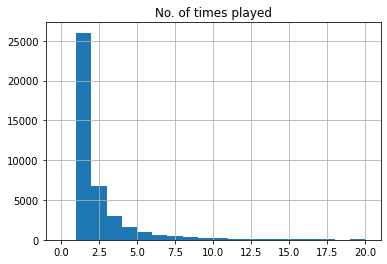

In [16]:
# Distribution of play counts per song

%matplotlib inline
count_per_song.hist(bins=20, range=(0,20))

In [17]:
# Renaming columns to original names

count_per_user.rename(columns = {'No. of songs played':'counts'}, inplace = True)
count_per_song.rename(columns = {'No. of times played':'counts'}, inplace = True)

### Analyzing the song play counts

In [18]:
#Summary statistics of counts variable

df['counts'].describe().transpose()

count    100000.000000
mean          3.232610
std           7.530945
min           1.000000
25%           1.000000
50%           1.000000
75%           3.000000
max         450.000000
Name: counts, dtype: float64

In [19]:
print('Minimum no. of times a song was listened to by a user is: %d' %(df.counts.min()))
print('Maximum no. of times a song was listened to by a user is: %d' %(df.counts.max()))

Minimum no. of times a song was listened to by a user is: 1
Maximum no. of times a song was listened to by a user is: 450


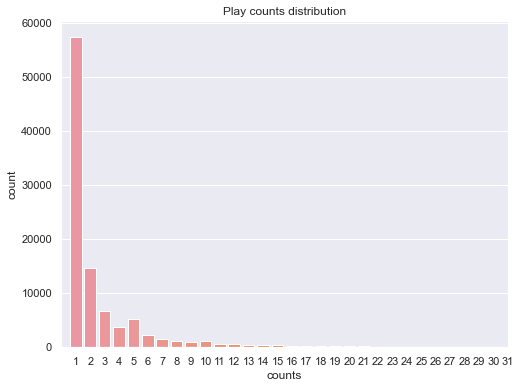

In [20]:
# Distribution of counts

sns.set(rc={'figure.figsize':(8,6)})
fig, ax = plt.subplots()
sns.countplot(x = df['counts'], ax=ax).set_title('Play counts distribution')
ax.set_xlim(-1,30)
plt.show()

### Taking a subset of the data to make it less sparse

Since predictions will be easier on denser data, we remove songs that are played less frequently and users that have played very few songs.

In [21]:
# Removing songs that have been played by less than 5 unique users
filtered_count_per_song = count_per_song[count_per_song.counts >= 5]

# build a list of songids to keep
filtered_songs = filtered_count_per_song.index.tolist()

In [22]:
# Removing users that have played less than 5 unique songs
filtered_count_per_user = count_per_user[count_per_user.counts >= 5]

# build a list of userids to keep
filtered_users = filtered_count_per_user.index.tolist()

In [23]:
# Filtering data based on above conditions

filtered_data = df[df.songid.isin(filtered_songs)]
filtered_data = filtered_data[filtered_data.userid.isin(filtered_users)]
print('Rows in filtered matrix:', len(filtered_data))

Rows in filtered matrix: 45310


In [24]:
df = filtered_data
filtered_data.head()

,userid,songid,counts
0,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOBONKR12A58A7A7E0,1
1,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOEGIYH12A6D4FC0E3,1
2,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOFLJQZ12A6D4FADA6,1
3,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOHTKMO12AB01843B0,1
4,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SODQZCY12A6D4F9D11,1


In [25]:
# Unique number of songs and users

n_users = df.userid.unique().shape[0]
n_songs = df.songid.unique().shape[0]

print('Number of unique users: ', n_users)
print('Number of unique songs: ', n_songs)

Number of unique users:  7106
Number of unique songs:  3898


## Splitting the data into training and test sets

In [26]:
# Splitting the data randomly into training and test sets using a 70:30 ratio

train_data, test_data = train_test_split(df, test_size = 0.3, random_state=0)

print(train_data.head())
print(test_data.head())

                                         userid              songid  counts
35749  dcd64d899921cd082e79f5cd04b7719220d84943  SOSNJIT12A8159E8DB       1
72276  ba49dbd47bb820bb23b05f05cedf2b07ba5965da  SOUNNWW12AB018795D       1
51359  7992bb051e8e5126848d5ef389a009cf7fad2cbd  SOHVUZY12A8C133AA1       5
35271  425ce65a438508c42b90ad52a7e021e675b5442e  SOIDEEX12AF72ACB24       1
9433   9d05fc6bf1116e17dff791309a6fdcb6d03c1dcf  SOPPROJ12AB0184E18       4
                                         userid              songid  counts
72205  3a0e28d840e44d6ba552be30ca47986bcd9f375c  SOEHWGF12A6D4F8B2B       1
29701  c751971552d2303664469297dbdd562f8b9fdc65  SOJSQYL12A81C23901       1
9063   af166880a7e81419e583059c34d89a6b011baada  SOILFUU12AB017C75F       4
87410  59e969f74a843a6164ea3af080375c06ee0d9d47  SOSFSWB12AB018C99A       1
8814   23d7cde4945a1f4fc62f2b78b31502aa6e59ede8  SOLFXKT12AB017E3E0       1


In [27]:
print('Shape of training data: ',train_data.shape)
print('Shape of testing data: ',test_data.shape)

Shape of training data:  (31717, 3)
Shape of testing data:  (13593, 3)


### Creating pivot tables for both training and test datasets
The pivot table will contain the play counts for each song-user pair

In [28]:
train_matrix = train_data.pivot_table(values='counts', index='userid', columns='songid', fill_value=0)
test_matrix = test_data.pivot_table(values='counts', index='userid', columns='songid', fill_value=0)

In [29]:
train_matrix.head()

songid,SOAACPJ12A81C21360,SOAAFYH12A8C13717A,SOAAROC12A6D4FA420,SOAAVUV12AB0186646,SOAAWEE12A6D4FBEC8,SOABHYV12A6D4F6D0F,SOABJBU12A8C13F63F,SOABQTG12A6701F3DB,SOABTTR12A6D4FC2EB,SOACBLB12AB01871C7,...,SOZYBTI12A8C141B18,SOZYDZR12A8C13F4F0,SOZYSDT12A8C13BFD7,SOZYTWE12A3F1EA18B,SOZYUGZ12A8AE472AC,SOZZHQT12AB018B714,SOZZIOH12A67ADE300,SOZZLZN12A8AE48D6D,SOZZTCU12AB0182C58,SOZZTNF12A8C139916
userid,,,,,,,,,,,,,,,,,,,,,
0011d5f4fb02ff276763d385c3f2ded2b00ad94a,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
002511b392561fc1d426d875c386b356a6fc5702,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
002dfbc3c073b55a64a4abab34c0ca1f13897f1c,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
003998bc33cddeba02428a43391c6716e523c8f7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0042d2027dfa0340e31d2aa875c4be229730efb7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
#Mapping userIds to indices in test matrix (for predictions)

train_matrix2 = train_matrix
train_matrix2['user_index'] = np.arange(0, train_matrix2.shape[0], 1)
train_matrix2.set_index(['user_index'], inplace=True)
train_matrix2.head()
l1 = train_matrix2.columns.tolist()

In [31]:
# Calculating the density of the train and test matrices

def pivot_matrix_density(matrix):
    songs_listened = np.count_nonzero(matrix)
    print('Available values = ', songs_listened)
    possible_num_of_songs = matrix.shape[0] * matrix.shape[1]
    print('Possible number of values = ', possible_num_of_songs)
    density = (songs_listened/possible_num_of_songs)
    density *= 100
    print ('Density: {:4.5f}%'.format(density))

In [32]:
print('Train matrix:')
pivot_matrix_density(train_matrix)
print('\nTest matrix:')
pivot_matrix_density(test_matrix)

Train matrix:
Available values =  31717
Possible number of values =  26479200
Density: 0.11978%

Test matrix:
Available values =  13593
Possible number of values =  19727998
Density: 0.06890%


In [33]:
# Converting dataframes to numpy arrays

train_matrix_np = train_matrix.values
test_matrix_np = test_matrix.values
print(train_matrix_np.shape)
print(test_matrix_np.shape)

(6800, 3894)
(5506, 3583)


##  Memory-Based User-Item Collaborative Filtering

In [34]:
# User-based CF predictions

def cf_predict(counts, similarity, type='user'):
    mean_user_counts = counts.mean(axis=1)
    counts_diff = (counts - mean_user_counts[:, np.newaxis])  # Used np.newaxis so that mean_user_rating has same format as ratings
    pred = mean_user_counts[:, np.newaxis] + similarity.dot(counts_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    return pred

Using 3 different metrics to create find the pairwise distances between songs ans users:
1. Cosine similarity
2. Euclidean distance
3. Pearson correlation

In [35]:
# Using the cosine similarity metric
user_similarity_cosine = pairwise_distances(train_matrix_np, metric='cosine')

# Running prediction function
user_prediction_cosine = cf_predict(train_matrix_np, user_similarity_cosine, type='user')

In [36]:
# Using the euclidean distance similarity metric
user_similarity_euclid = pairwise_distances(train_matrix_np, metric='euclidean')

# Running prediction function
user_prediction_euclid = cf_predict(train_matrix_np, user_similarity_euclid, type='user')

In [37]:
# Using the pearson-correlation similarity metric
# user_similarity_corr = pairwise_distances(train_matrix_np, metric='correlation')

# Running prediction function
# user_prediction_corr = predict(train_matrix_np, user_similarity_corr, type='user')

### The prediction matrix contains the predicted play counts for each user-song pair

In [38]:
user_prediction_cosine_df = pd.DataFrame(user_prediction_cosine)
print("Cosine similarity predictions matrix")
user_prediction_cosine_df.head()

Cosine similarity predictions matrix


,0,1,2,3,4,5,6,7,8,9,...,3884,3885,3886,3887,3888,3889,3890,3891,3892,3893
0,0.002527,0.003708,0.002085,0.006501,0.008430,0.005036,0.012402,0.003220,0.003265,0.024662,...,0.005774,0.005479,0.016398,0.004446,0.004298,0.005619,0.002521,0.003413,0.003118,0.003118
1,-0.003132,-0.001955,-0.003573,0.000829,0.002753,-0.000631,0.006711,-0.002396,-0.002396,0.018934,...,0.000105,-0.000189,0.010696,-0.001219,-0.001366,-0.000042,-0.003132,-0.002249,-0.002543,-0.002543
2,0.005618,0.006791,0.005175,0.009591,0.011530,0.007908,0.015508,0.006357,0.006357,0.027786,...,0.008870,0.008550,0.019510,0.007540,0.007392,0.008713,0.005618,0.006505,0.006210,0.006195
3,-0.003389,-0.002212,-0.003830,0.000583,0.002495,-0.000888,0.006467,-0.002653,-0.002653,0.018676,...,-0.000152,-0.000447,0.010439,-0.001476,-0.001623,-0.000300,-0.003389,-0.002506,-0.002800,-0.002800
4,-0.002359,-0.001180,-0.002800,0.001618,0.003532,0.000145,0.007509,-0.001622,-0.001622,0.019732,...,0.000881,0.000587,0.011485,-0.000444,-0.000591,0.000734,-0.002359,-0.001475,-0.001770,-0.001770


In [39]:
user_prediction_euclid_df = pd.DataFrame(user_prediction_euclid)
print("Euclidean distance Predictions matrix")
user_prediction_euclid_df.head()

Euclidean distance Predictions matrix


,0,1,2,3,4,5,6,7,8,9,...,3884,3885,3886,3887,3888,3889,3890,3891,3892,3893
0,-0.003926,-0.004530,-0.006213,0.002659,0.004062,-0.000989,0.019099,-0.005140,-0.005436,0.136069,...,-0.001712,-0.001787,0.022776,-0.003142,-0.000530,-0.000340,-0.005823,-0.004779,-0.005300,-0.005369
1,-0.012618,-0.013942,-0.015890,-0.004482,-0.002957,-0.009069,0.017461,-0.014741,-0.015293,0.179294,...,-0.010267,-0.010409,0.021290,-0.012205,-0.008217,-0.008372,-0.015462,-0.014177,-0.014896,-0.015062
2,0.002457,0.002795,0.001226,0.007601,0.009062,0.004822,0.018092,0.002331,0.002236,0.082454,...,0.005009,0.004842,0.021898,0.003820,0.004830,0.005615,0.001632,0.002529,0.002171,0.002152
3,-0.013032,-0.014390,-0.016356,-0.004808,-0.003274,-0.009446,0.017417,-0.015202,-0.015762,0.181464,...,-0.010664,-0.010811,0.021259,-0.012630,-0.008579,-0.008746,-0.015923,-0.014622,-0.015354,-0.015523
4,-0.011250,-0.012446,-0.014328,-0.003434,-0.001948,-0.007834,0.017437,-0.013194,-0.013707,0.170753,...,-0.008956,-0.009079,0.021213,-0.010785,-0.007047,-0.007150,-0.013913,-0.012685,-0.013361,-0.013509


In [40]:
# user_prediction_corr_df = pd.DataFrame(user_prediction_man)
# print("Pearson correlation Predictions matrix")
# user_prediction_corr_df.head()

In [41]:
# Recommend the songs with highest prediction

def recommend_songs(userID, pivot_df, preds_df, num_recommendations, l1):
    # index starts at 0  
    user_idx = userID - 1 

    print('userid: ', userID)
    user_predictions = preds_df.loc[user_idx, :]
    sorted_user_predictions = user_predictions.sort_values(ascending=False)
    #print(sorted_user_predictions)
    
    temp = pd.DataFrame(sorted_user_predictions)
    temp.columns = ['Prediction score']
    temp = temp.head(num_recommendations)
    
    final = list()
    l2 = temp.index.tolist()
    for i in l2:
        pid = l1[i]
        final.append(pid)
        
    temp.index = final
    temp.index.name = 'Recommended songs'
    print(temp)

### Making recommendations (user-based)

In [42]:
# Cosine similarity metric
print("Recommendations based on cosine similarity:\n ")
num_recs = 5

# Randomly choosing userids to recommend songs to them

userID = np.random.choice(train_matrix.shape[0])
recommend_songs(userID, train_matrix2, user_prediction_cosine_df, num_recs, l1)

userID = np.random.choice(train_matrix.shape[0])
recommend_songs(userID, train_matrix2, user_prediction_cosine_df, num_recs, l1)

userID = np.random.choice(train_matrix.shape[0])
recommend_songs(userID, train_matrix2, user_prediction_cosine_df, num_recs, l1)

Recommendations based on cosine similarity:
 
userid:  2484
                    Prediction score
Recommended songs                   
SOBONKR12A58A7A7E0          0.282590
SOAUWYT12A81C206F1          0.235795
SOSXLTC12AF72A7F54          0.189442
SOFRQTD12A81C233C0          0.144085
SOAXGDH12A8C13F8A1          0.129991
userid:  2303
                    Prediction score
Recommended songs                   
SOBONKR12A58A7A7E0          0.280005
SOAUWYT12A81C206F1          0.233198
SOSXLTC12AF72A7F54          0.186579
SOFRQTD12A81C233C0          0.141665
SOAXGDH12A8C13F8A1          0.127429
userid:  5266
                    Prediction score
Recommended songs                   
SOBONKR12A58A7A7E0          0.276663
SOAUWYT12A81C206F1          0.229871
SOSXLTC12AF72A7F54          0.183476
SOFRQTD12A81C233C0          0.138200
SOAXGDH12A8C13F8A1          0.124034


In [43]:
# Euclidean distance similarity metric
print("Recommendations based on euclidean distance:\n ")
num_recs = 5

# Randomly choosing userids to recommend songs to them

userID = np.random.choice(train_matrix.shape[0])
recommend_songs(userID, train_matrix2, user_prediction_euclid_df, num_recs, l1)

userID = np.random.choice(train_matrix.shape[0])
recommend_songs(100, train_matrix2, user_prediction_euclid_df, num_recs, l1)

userID = np.random.choice(train_matrix.shape[0])
recommend_songs(2000, train_matrix2, user_prediction_euclid_df, num_recs, l1)

Recommendations based on euclidean distance:
 
userid:  5990
                    Prediction score
Recommended songs                   
SODCNEE12A6310E037          1.800826
SONQCXC12A6D4F6A37          0.801883
SOBONKR12A58A7A7E0          0.746727
SOSJRJP12A6D4F826F          0.738195
SOAUWYT12A81C206F1          0.687352
userid:  100
                    Prediction score
Recommended songs                   
SODCNEE12A6310E037          3.177717
SONQCXC12A6D4F6A37          1.400060
SOSJRJP12A6D4F826F          1.291104
SOBONKR12A58A7A7E0          1.233927
SOAUWYT12A81C206F1          1.139194
userid:  2000
                    Prediction score
Recommended songs                   
SODCNEE12A6310E037          2.792355
SONQCXC12A6D4F6A37          1.232486
SOSJRJP12A6D4F826F          1.136458
SOBONKR12A58A7A7E0          1.093753
SOAUWYT12A81C206F1          1.009427


### Evaluation of results

In [44]:
# Function to calculate RMSE for predictions
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten() 
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))

In [45]:
print ('User-based CF using cosine similarity RMSE: ' + str(rmse(user_prediction_cosine, test_matrix_np)))
print ('User-based CF using euclidean distance RMSE: ' + str(rmse(user_prediction_euclid, test_matrix_np)))

User-based CF using cosine similarity RMSE: 8.693122621968065
User-based CF using euclidean distance RMSE: 8.69177208144704


## Model-Based Collaborative Filtering

### Method 1:  MATRIX FACTORIZATION (SVD)

In [49]:
#Converting counts to float type

train_matrix = train_matrix.astype(float)

### Singular Value Decomposition on the pivot table

In [50]:
# SVD algorithm
from scipy.sparse.linalg import svds

U, sigma, Vt = svds(train_matrix, k = 10)

# Converting sigma to diagonal matrix
sigma = np.diag(sigma)

In [51]:
#Predicted ratings
all_user_predicted_counts = np.dot(np.dot(U, sigma), Vt) 

# Convert predicted counts to a dataframe
preds_df = pd.DataFrame(all_user_predicted_counts, columns = train_matrix.columns)
preds_df.head()

songid,SOAACPJ12A81C21360,SOAAFYH12A8C13717A,SOAAROC12A6D4FA420,SOAAVUV12AB0186646,SOAAWEE12A6D4FBEC8,SOABHYV12A6D4F6D0F,SOABJBU12A8C13F63F,SOABQTG12A6701F3DB,SOABTTR12A6D4FC2EB,SOACBLB12AB01871C7,...,SOZYBTI12A8C141B18,SOZYDZR12A8C13F4F0,SOZYSDT12A8C13BFD7,SOZYTWE12A3F1EA18B,SOZYUGZ12A8AE472AC,SOZZHQT12AB018B714,SOZZIOH12A67ADE300,SOZZLZN12A8AE48D6D,SOZZTCU12AB0182C58,SOZZTNF12A8C139916
0,2.766263e-10,3.197560e-06,8.305540e-10,6.051356e-06,-3.329836e-07,1.861736e-05,2.770591e-05,2.738202e-08,1.181242e-07,2.227941e-07,...,7.069341e-07,1.717794e-05,3.311700e-06,1.467786e-07,4.828612e-06,-6.301770e-07,1.640543e-08,7.021493e-09,3.281225e-08,3.367849e-07
1,1.800153e-13,9.758748e-10,2.496838e-13,3.013800e-08,3.907127e-09,5.444732e-09,8.166046e-09,2.791371e-11,3.262952e-11,5.049912e-10,...,2.102901e-10,4.654199e-09,5.330363e-09,1.221242e-10,1.346020e-09,1.059966e-08,8.856119e-12,5.056230e-12,1.598891e-12,3.432719e-09
2,2.678196e-08,1.014213e-04,3.987691e-08,5.040857e-03,6.046645e-04,7.506530e-04,7.698509e-04,4.938881e-06,4.409590e-06,6.494684e-05,...,3.213131e-05,1.044593e-03,7.289066e-05,7.736090e-06,1.000529e-04,1.764692e-03,8.298521e-07,6.359349e-07,8.975326e-07,5.844118e-04
3,9.757942e-17,5.985652e-13,2.209684e-16,1.326570e-11,1.744993e-12,3.276583e-12,6.801253e-12,1.385454e-14,2.197746e-14,3.202094e-13,...,1.362293e-13,2.609821e-12,4.399794e-11,3.283706e-14,9.570751e-13,4.664461e-12,3.910906e-15,2.098431e-15,1.235950e-15,2.084256e-12
4,3.048421e-11,1.249359e-07,5.037409e-11,5.855473e-06,7.255075e-07,7.689814e-07,1.251625e-06,5.225782e-09,4.928419e-09,9.860684e-08,...,3.436565e-08,8.165382e-07,6.268082e-06,9.625980e-09,1.640773e-07,2.061820e-06,9.791683e-10,6.927571e-10,1.340282e-10,7.394260e-07


In [52]:
preds_df.shape

(6800, 3894)

In [53]:
# Recommend the songs with the highest predicted play count

def recommend_items(userID, pivot_df, preds_df, num_recommendations):
    # index starts at 0  
    user_idx = userID-1 
    
    # Get and sort the user's play counts
    sorted_user_counts = pivot_df.iloc[user_idx].sort_values(ascending=False)
    
    # Get and sort the user's predicted play counts
    sorted_user_predictions = preds_df.iloc[user_idx].sort_values(ascending=False)
    
    temp = pd.concat([sorted_user_counts, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended Song'
    temp.columns = ['Actual play count', 'Predicted play count']
    temp = temp.loc[temp["Actual play count"] == 0]   
    temp = temp.sort_values('Predicted play count', ascending=False)
    print('\nRecommended songs for userid = {}:\n'.format(userID))
    print(temp.head(num_recommendations))

### Making Recommendations (user-based)

In [54]:
# Recommending top 5 songs to the user
num_recommendations = 5

# Selecting userids randomly
userID = np.random.choice(train_matrix.shape[0])
recommend_items(userID, train_matrix, preds_df, num_recommendations)

userID = np.random.choice(train_matrix.shape[0])
recommend_items(userID, train_matrix, preds_df, num_recommendations)

userID = np.random.choice(train_matrix.shape[0])
recommend_items(userID, train_matrix, preds_df, num_recommendations)


Recommended songs for userid = 3676:

                    Actual play count  Predicted play count
Recommended Song                                           
SOAUWYT12A81C206F1                0.0              0.000129
SOSXLTC12AF72A7F54                0.0              0.000054
SOBONKR12A58A7A7E0                0.0              0.000030
SOVDSJC12A58A7A271                0.0              0.000016
SODCNEE12A6310E037                0.0              0.000015

Recommended songs for userid = 554:

                    Actual play count  Predicted play count
Recommended Song                                           
SODCNEE12A6310E037                0.0              0.023536
SOBONKR12A58A7A7E0                0.0              0.005475
SOWLFNL12AB017DB20                0.0              0.002433
SOAXGDH12A8C13F8A1                0.0              0.001331
SORJICW12A8C13640D                0.0              0.000885

Recommended songs for userid = 6771:

                    Actual play count  Predi

### Evaluating result

In [55]:
rmse_df = pd.concat([test_matrix.mean(), preds_df.mean()], axis=1)
rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
print(rmse_df.shape)
rmse_df['item_index'] = np.arange(0, rmse_df.shape[0], 1)
rmse_df.head()

(3898, 2)


,Avg_actual_ratings,Avg_predicted_ratings,item_index
songid,,,
SOAACPJ12A81C21360,0.001453,4.334219e-09,0
SOAAFYH12A8C13717A,0.000363,1.948496e-05,1
SOAAROC12A6D4FA420,0.000726,7.270661e-09,2
SOAAVUV12AB0186646,0.009444,7.351448e-04,3
SOAAWEE12A6D4FBEC8,0.004177,9.266116e-05,4


In [56]:
RMSE = round((((rmse_df.Avg_actual_ratings - rmse_df.Avg_predicted_ratings) ** 2).mean() ** 0.5), 5)
print('\nRMSE of the SVD Model = {} \n'.format(RMSE))


RMSE of the SVD Model = 0.00698 



### Method 2: K-NEAREST NEIGHBORS

In [57]:
# Creating user-song pivot table

pivot_matrix = df.pivot_table(values='counts', index='songid', columns='userid').fillna(0)
pivot_matrix.head()

userid,0011d5f4fb02ff276763d385c3f2ded2b00ad94a,002511b392561fc1d426d875c386b356a6fc5702,002dfbc3c073b55a64a4abab34c0ca1f13897f1c,003998bc33cddeba02428a43391c6716e523c8f7,0042d2027dfa0340e31d2aa875c4be229730efb7,004433e6e1ad294af96331c00f8742f4fce99d50,0051b37d4665b4e6e2e1f048b671c19618c0a931,00587ee69421cb6abc50898714c23583f1f4e230,005aa4c4bc1dc74114b8bd6ffdca64c1d218474f,005b1fab38cdeb9d5bb97debcf73b44050994a3e,...,ff9e31adc2f001172ca982fcc4fcca07ec04370c,ffb046d6935a3b5ad4673d45ae277630ca03ddc6,ffc40a866e94948d8a223a3e98cc48a58d13a45d,ffc683d098d818421f22363b150a19fd7d307764,ffca2f5069c381b20171dc14404b2e5e1141692b,ffd000dee03972e48d6462118589fe7819e602f3,ffd41f0f4c56e011d86a5005439f3468fd29d1d9,ffdfbc60afdcdcb630d3b667ca3a083b09ed6212,ffe2811be1a471ea1d30fd646d815d272aef7d4d,ffe98099df91d5ff4a9ab02f58bb9dc87b278cb2
songid,,,,,,,,,,,,,,,,,,,,,
SOAACPJ12A81C21360,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SOAAFYH12A8C13717A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SOAAROC12A6D4FA420,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SOAAVUV12AB0186646,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SOAAWEE12A6D4FBEC8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [58]:
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix

csr_matrix = csr_matrix(pivot_matrix.values) # Converting to an array matrix
model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
knn_model = model_knn.fit(csr_matrix)

In [59]:
def recommend_knn(query_id, pivot_matrix):
    distances, indices = knn_model.kneighbors(pivot_matrix.iloc[query_id, :].values.reshape(1, -1), n_neighbors = 6)
    rec_songs = []
    avg_actual_count = []
    cosine_dist = []
    for i in range(0, len(distances.flatten())):
        if i == 0:
            print('\nRecommended songs similar to song {0}:\n'.format(pivot_matrix.index[query_id])) # First song is the query song itself
        else:
            rec_song_id = pivot_matrix.index[indices.flatten()[i]] # Remaining songs are recommended
            rec_songs.append(rec_song_id) 
            avg_actual_count.append(pivot_matrix.loc[rec_song_id].mean())
            cosine_dist.append(distances.flatten()[i])

    rec_songs = pd.Series(rec_songs)
    avg_actual_count = pd.Series(avg_actual_count)
    cosine_dist = pd.Series(cosine_dist)
    
    temp = pd.concat([rec_songs, avg_actual_count, cosine_dist], axis = 1)
    temp.columns = ['Song ID', 'Avg play count', 'Cosine distance']  
    temp = temp.sort_values('Cosine distance', ascending=True)
    print(temp)


### Making recommendations (song-based)

In [61]:
query_id = np.random.choice(pivot_matrix.shape[0])
recommend_knn(query_id, pivot_matrix)

query_id = np.random.choice(pivot_matrix.shape[0])
recommend_knn(query_id, pivot_matrix)

query_id = np.random.choice(pivot_matrix.shape[0])
recommend_knn(query_id, pivot_matrix)


Recommended songs similar to song SODBSUF12A8C141975:

              Song ID  Avg play count  Cosine distance
0  SOINIUZ12A67ADF6D8        0.003800         0.164031
1  SOBEHXG12A8C138D22        0.005910         0.302851
2  SOLMKTS12A8AE46C27        0.006896         0.595528
3  SOQKZMA12A8AE48F76        0.007599         0.659323
4  SOWQEXV12A6701E3C4        0.001829         0.696178

Recommended songs similar to song SODYQBI12A8AE48DB4:

              Song ID  Avg play count  Cosine distance
0  SOMYETD12A6D4F8541        0.004081         0.449858
1  SOVIKOY12AB018627D        0.001548         0.456007
2  SOSJOEN12A8C13B934        0.002815         0.570996
3  SOLMXQE12A8AE46E32        0.002815         0.618644
4  SOAHVLJ12A58A76DD6        0.001689         0.695835

Recommended songs similar to song SOSXSMM12B0B808B45:

              Song ID  Avg play count  Cosine distance
0  SOPEAMI12A6701E94B        0.001689         0.300000
1  SOHTWLT12A8C13CFE1        0.001548         0.646185
2  SOQL